# Granger Causality Analysis for Infant EEG Data

This notebook performs Granger causality analysis on infant EEG data to identify causal relationships between different brain regions. Granger causality measures whether one time series can predict another time series better than the series can predict itself.

## Analysis Steps:
1. **Data Loading and Preprocessing**
   - Load EEG data from .edf files
   - Filter signals (0.5-30 Hz bandpass)
   - Extract standard EEG channels
   - Downsample for computational efficiency

2. **Granger Causality Computation**
   - Calculate GC for all channel pairs
   - Optimize lag parameters (max_lag=2-10)
   - Apply significance testing (p < 0.05)
   - Generate connectivity matrices

3. **Visualization and Network Analysis**
   - Plot connectivity heatmaps
   - Create network graphs with thresholding
   - Analyze node degree statistics
   - Map brain region interactions

4. **Temporal Dynamics Analysis**
   - Segment data into time windows
   - Track connectivity evolution over time
   - Assess connection stability/consistency
   - Compare different window sizes

5. **Statistical Analysis and Interpretation**
   - Identify strongest connections
   - Analyze brain region connectivity patterns
   - Generate summary statistics
   - Export results for further analysis

6. **Results Export and Documentation**
   - Save connectivity matrices and statistics
   - Generate publication-ready plots
   - Create analysis summary reports

In [23]:
# EEG Granger Causality Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import os
import re
import warnings
from scipy import signal
from statsmodels.tsa.stattools import grangercausalitytests
import networkx as nx

# Clean output
warnings.filterwarnings('ignore')
mne.set_log_level('WARNING')

# Better plots
plt.rcParams['figure.dpi'] = 100
sns.set_palette("husl")

# Reproducible results
np.random.seed(42)

print("✓ Ready to analyze brain connectivity!")

✓ Ready to analyze brain connectivity!


## 1. Data Loading and Preprocessing

In [24]:
def load_eeg_data(file_path):
    """Load EEG data and show basic info"""
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    
    print(f"✓ Loaded EEG data: {len(raw.ch_names)} channels, {raw.times[-1]:.1f}s duration")
    print(f"  Channels: {raw.ch_names}")
    
    return raw

# Load the data
data_path = './Dataset/Infants_data/sub-NORB00003_ses-1_task-EEG_eeg.edf'
raw = load_eeg_data(data_path)

✓ Loaded EEG data: 19 channels, 1784.0s duration
  Channels: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']


In [25]:
def setup_output_folder(file_path):
    """Create output folder based on filename"""
    # Get filename without extension
    filename = os.path.basename(file_path).replace('.edf', '')
    
    # Create output directory
    output_dir = f'./Dataset/Infants_data_output/{filename}'
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"✓ Output folder: {output_dir}")
    return output_dir

# Setup output directory
output_dir = setup_output_folder(data_path)

✓ Output folder: ./Dataset/Infants_data_output/sub-NORB00003_ses-1_task-EEG_eeg


In [26]:
def preprocess_eeg(raw, lowpass=30, highpass=0.5):
    """Clean and filter EEG data"""
    # Filter the data
    raw_filtered = raw.copy()
    raw_filtered.filter(highpass, lowpass, fir_design='firwin', verbose=False)
    
    # Get data and extract EEG channels only
    data, times = raw_filtered[:, :]
    
    # Standard EEG electrodes
    eeg_names = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'FZ', 'C3', 'C4', 'CZ', 
                 'P3', 'P4', 'PZ', 'O1', 'O2', 'T3', 'T4', 'T5', 'T6']
    
    # Find EEG channels
    eeg_indices = []
    eeg_channels = []
    
    for i, ch in enumerate(raw_filtered.ch_names):
        if ch in eeg_names:
            eeg_indices.append(i)
            eeg_channels.append(ch)
    
    # Extract clean EEG data
    clean_data = data[eeg_indices, :]
    
    print(f"✓ Preprocessed: {len(eeg_channels)} EEG channels")
    print(f"  Channels: {eeg_channels}")
    print(f"  Data shape: {clean_data.shape}")
    
    return clean_data, eeg_channels, times

# Preprocess the data
eeg_data, channel_names, times = preprocess_eeg(raw)
sampling_freq = raw.info['sfreq']

✓ Preprocessed: 19 EEG channels
  Channels: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']
  Data shape: (19, 356800)


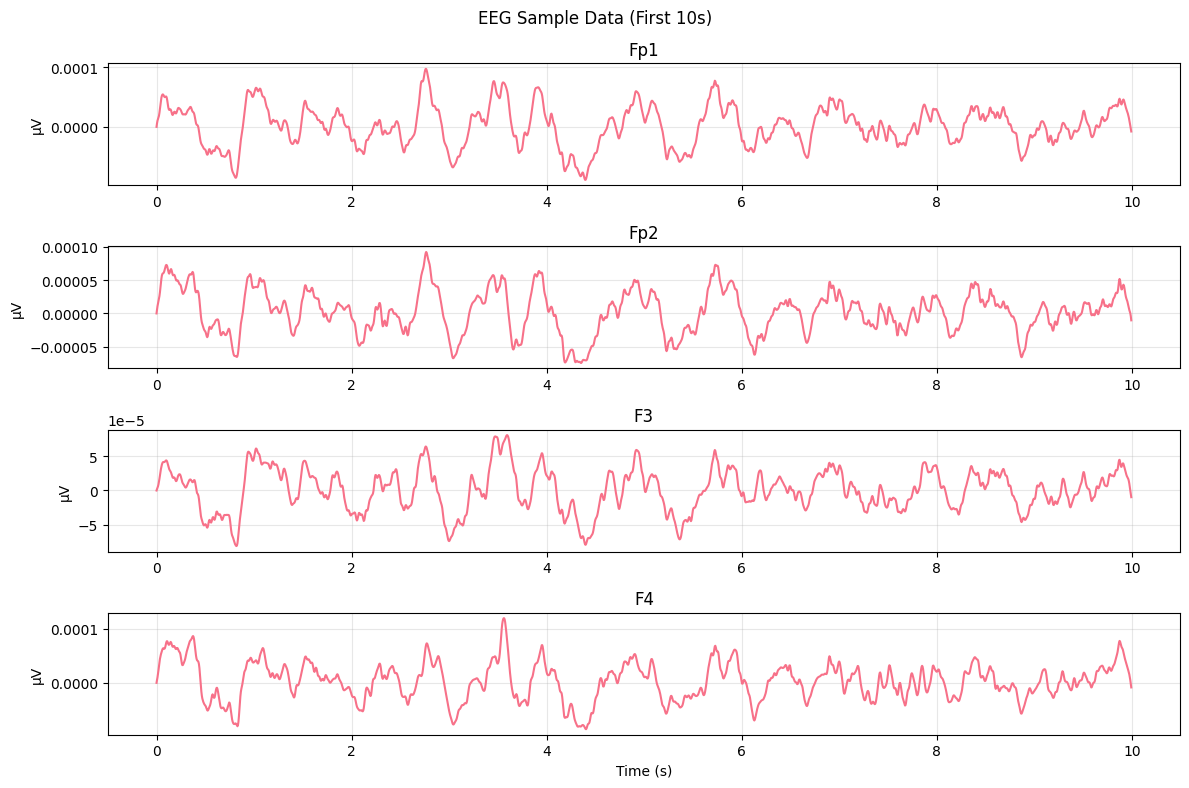

In [27]:
# Visualize sample EEG data
def plot_eeg_sample(data, channels, times, duration=10, save_path=None):
    """Plot first 4 EEG channels for quick visualization"""
    # Calculate time window
    samples = int(duration * sampling_freq)
    time_slice = slice(0, min(samples, data.shape[1]))
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    
    for i in range(4):
        if i < len(channels):
            axes[i].plot(times[time_slice], data[i, time_slice])
            axes[i].set_title(f'{channels[i]}')
            axes[i].set_ylabel('µV')
            axes[i].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Time (s)')
    plt.suptitle(f'EEG Sample Data (First {duration}s)')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot sample data
plot_eeg_sample(
    eeg_data, channel_names, times, 
    duration=10,
    save_path=os.path.join(output_dir, 'eeg_sample_data.png')
)

## 2. Granger Causality Analysis Functions

In [28]:
def prepare_data(data, original_fs, target_fs=100, max_duration=320):
    """Downsample and trim data for faster computation"""
    # Ensure input is numpy array
    data = np.asarray(data)
    
    # Skip downsampling if not needed
    if original_fs <= target_fs:
        processed_data = data.copy()
        new_fs = original_fs
    else:
        # Downsample using scipy
        from scipy import signal
        n_new = int(data.shape[1] * target_fs / original_fs)
        processed_data = np.asarray(signal.resample(data, n_new, axis=1))
        new_fs = target_fs
        print(f"✓ Downsampled: {original_fs} → {new_fs} Hz")
    
    # Trim to max duration
    max_samples = int(max_duration * new_fs)
    if processed_data.shape[1] > max_samples:
        processed_data = processed_data[:, :max_samples]
        print(f"✓ Using first {max_duration}s: {processed_data.shape}")
    else:
        print(f"✓ Using all data: {processed_data.shape}")
    
    return processed_data, new_fs

# Process the data
eeg_subset, new_fs = prepare_data(eeg_data, sampling_freq, target_fs=100, max_duration=320)

✓ Downsampled: 200.0 → 100 Hz
✓ Using first 320s: (19, 32000)


In [29]:
def calculate_granger_causality(data, channel_names, max_lag=10, alpha=0.05):
    """Calculate Granger causality between all channel pairs"""
    n_channels = len(channel_names)
    gc_matrix = np.zeros((n_channels, n_channels))
    p_values = np.ones((n_channels, n_channels))
    
    print(f"Calculating Granger causality for {n_channels} channels...")
    
    for i in range(n_channels):
        for j in range(n_channels):
            if i != j:
                try:
                    # Test if channel i causes channel j
                    test_data = np.column_stack([data[j, :], data[i, :]])
                    result = grangercausalitytests(test_data, max_lag, verbose=False)
                    
                    # Get best result across all lags
                    best_result = min(
                        (result[lag][0]['ssr_ftest'] for lag in range(1, max_lag + 1)),
                        key=lambda x: x[1]  # Sort by p-value
                    )
                    
                    gc_matrix[i, j] = best_result[0]  # F-statistic
                    p_values[i, j] = best_result[1]   # p-value
                    
                except Exception as e:
                    print(f"Error: {channel_names[i]} → {channel_names[j]}: {e}")
                    # Values already initialized to 0 and 1
    
    return gc_matrix, p_values

def apply_significance_threshold(gc_matrix, p_values, alpha=0.05):
    """Apply significance threshold to GC matrix"""
    return np.where(p_values <= alpha, gc_matrix, 0)

In [30]:
print("Calculating Granger causality...")
gc_matrix, p_values = calculate_granger_causality(eeg_subset, channel_names, max_lag=2)
significant_gc = apply_significance_threshold(gc_matrix, p_values)

n_sig, n_total = np.sum(significant_gc > 0), len(channel_names) * (len(channel_names) - 1)
print(f"✓ Found {n_sig}/{n_total} significant connections ({n_sig/n_total*100:.1f}%)")

Calculating Granger causality...
Calculating Granger causality for 19 channels...
✓ Found 338/342 significant connections (98.8%)


## 3. Visualization of Results

Plotting connectivity matrices...


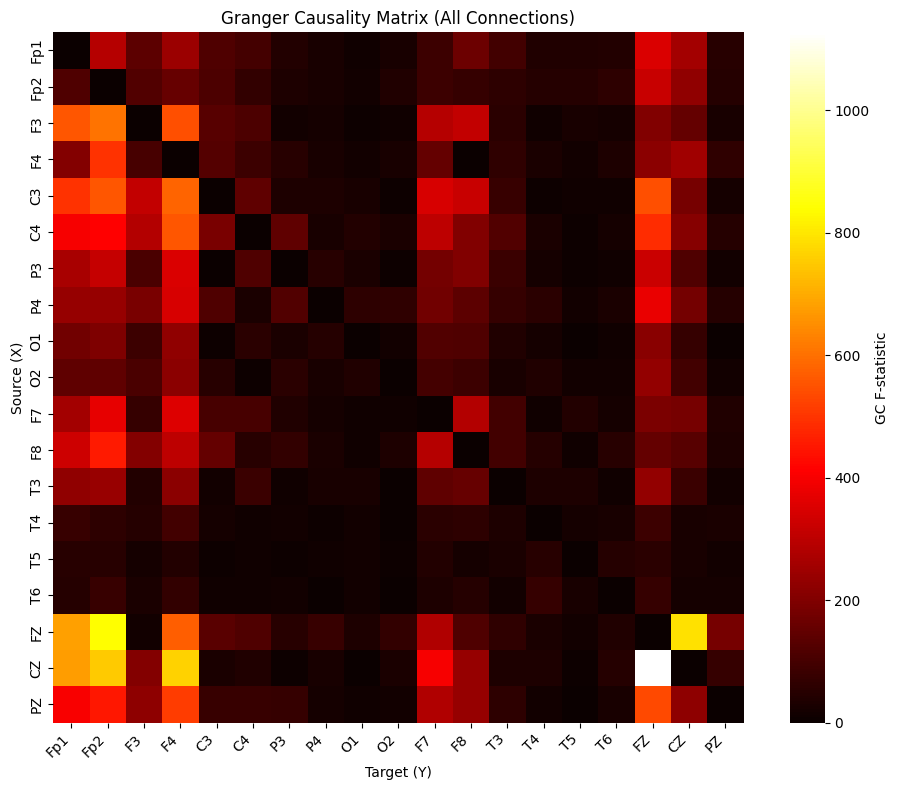

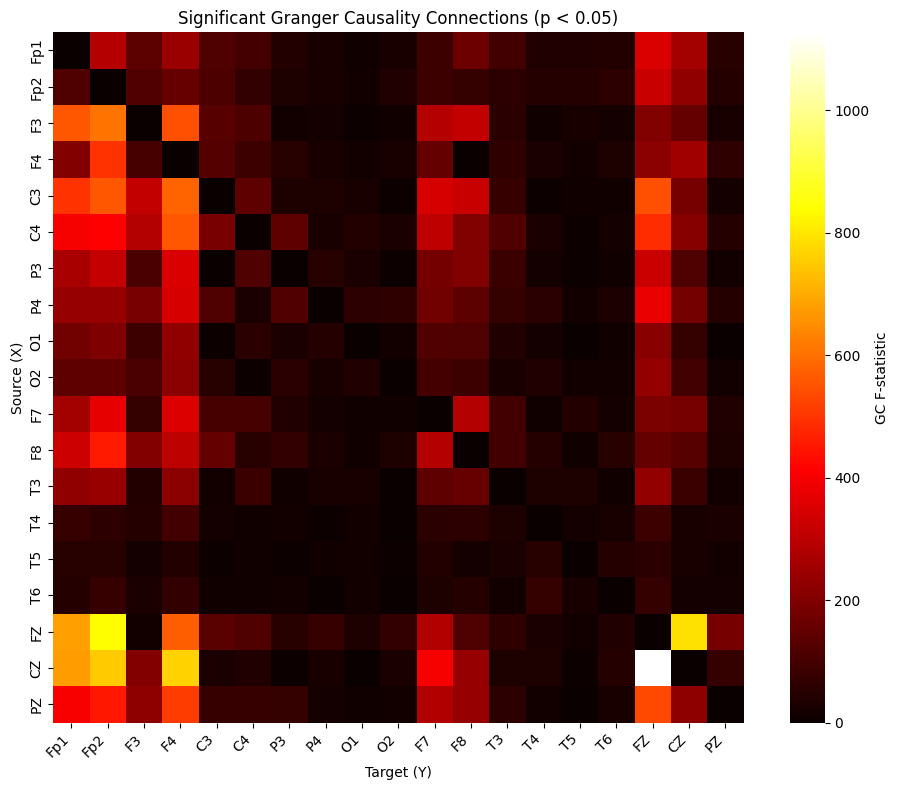

In [31]:
def plot_connectivity_matrix(matrix, channel_names, title, cmap='hot', save_path=None):
    """Plot connectivity matrix as heatmap"""
    plt.figure(figsize=(10, 8))
    
    # Create heatmap with seaborn (simpler and prettier)
    sns.heatmap(matrix, 
                xticklabels=channel_names, 
                yticklabels=channel_names,
                cmap=cmap, 
                cbar_kws={'label': 'GC F-statistic'},
                square=True)
    
    plt.title(title)
    plt.xlabel('Target (Y)')
    plt.ylabel('Source (X)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot both matrices
print("Plotting connectivity matrices...")

plot_connectivity_matrix(
    gc_matrix, channel_names, 
    'Granger Causality Matrix (All Connections)',
    save_path=os.path.join(output_dir, 'gc_matrix_all_connections.png')
)

plot_connectivity_matrix(
    significant_gc, channel_names,
    'Significant Granger Causality Connections (p < 0.05)',
    save_path=os.path.join(output_dir, 'gc_matrix_significant_connections.png')
)

Network: 19 nodes, 17 edges


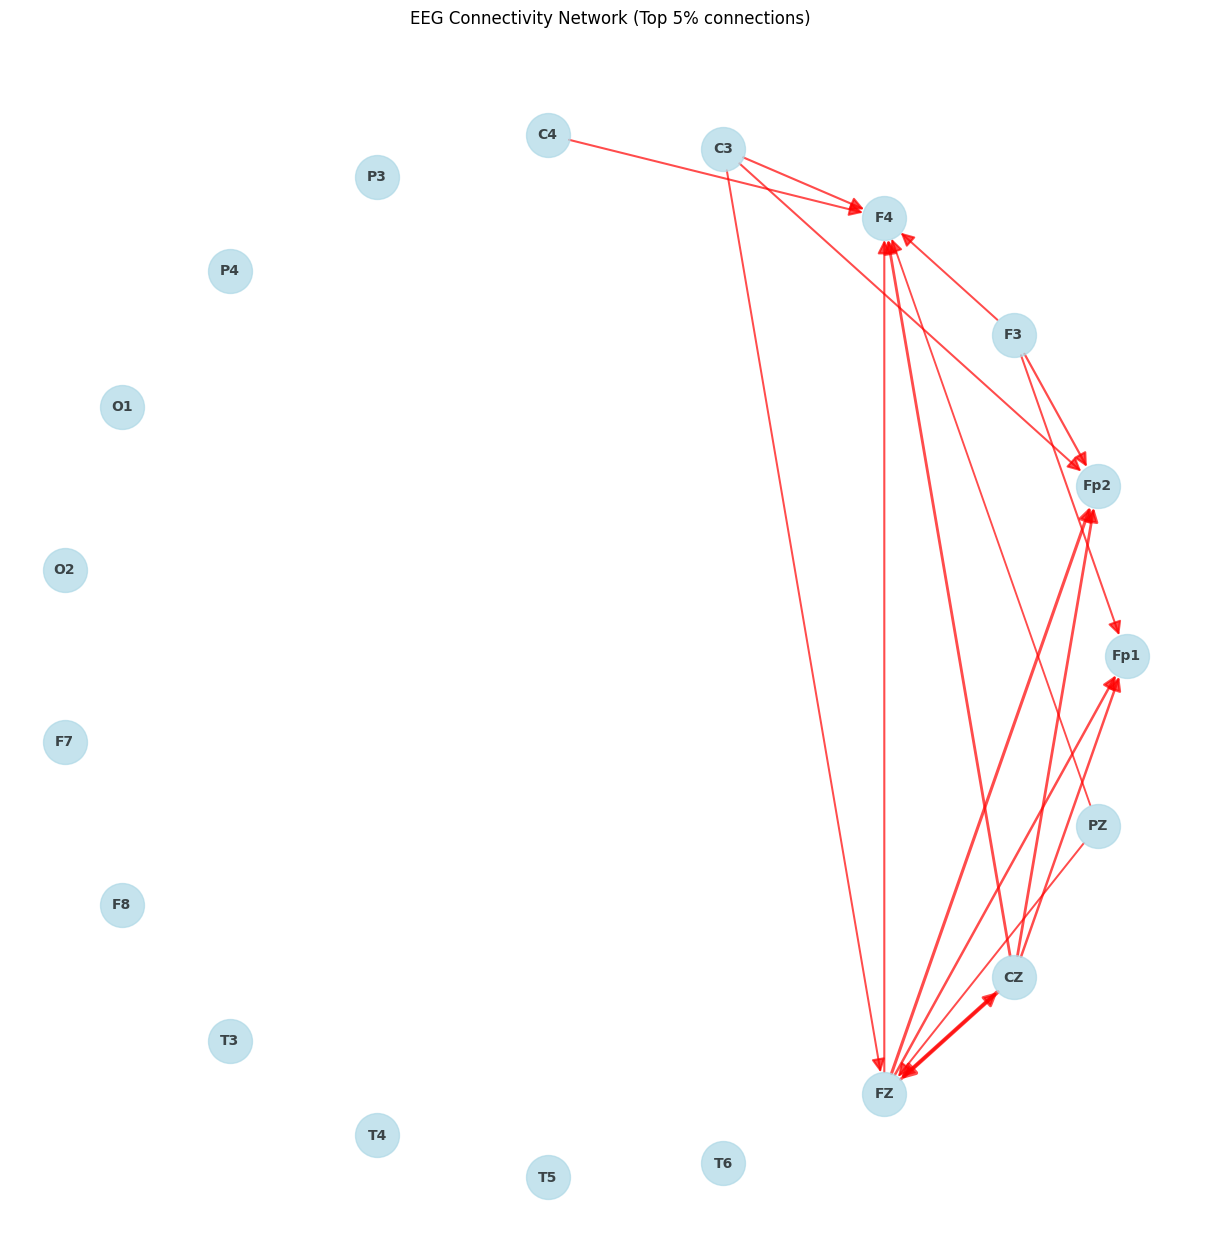

In [32]:
def plot_connectivity_network(gc_matrix, channel_names, threshold_percentile=80, save_path=None):
    """Plot connectivity as a network graph"""
    # Check if there are any non-zero values to calculate percentile
    non_zero_values = gc_matrix[gc_matrix > 0]
    if len(non_zero_values) == 0:
        print("No connections found in the matrix")
        return None
    
    # Apply threshold and create graph
    threshold = np.percentile(non_zero_values, threshold_percentile)
    thresholded_matrix = np.where(gc_matrix >= threshold, gc_matrix, 0)
    G = nx.from_numpy_array(thresholded_matrix, create_using=nx.DiGraph)
    
    # Create proper node mapping dictionary
    node_mapping = {}
    for i, name in enumerate(channel_names):
        node_mapping[i] = name
    
    # Relabel nodes with channel names
    G = nx.relabel_nodes(G, node_mapping)
    
    # Check if graph has edges
    if G.number_of_edges() == 0:
        print(f"No edges found with threshold percentile {threshold_percentile}")
        print(f"Try lowering the threshold_percentile (current: {threshold_percentile})")
        return G
    
    # Plot
    plt.figure(figsize=(12, 12))
    pos = nx.circular_layout(G)
    
    # Calculate edge widths safely
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    edge_widths = [weight / max_weight * 3 for weight in edge_weights]
    
    # Draw network
    nx.draw(G, pos, 
            node_color='lightblue', 
            node_size=1000,
            with_labels=True,
            font_size=10,
            font_weight='bold',
            edge_color='red',
            arrows=True,
            arrowsize=20,
            width=edge_widths,
            alpha=0.7)
    
    plt.title(f'EEG Connectivity Network (Top {100-threshold_percentile}% connections)')
    plt.axis('off')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    print(f"Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G

# Plot network
G = plot_connectivity_network(
    significant_gc, channel_names, 
    threshold_percentile=95,
    save_path=os.path.join(output_dir, 'connectivity_network.png')
)
plt.show()

## 4. Statistical Analysis and Summary

CONNECTIVITY SUMMARY
Significant: 338/342 (98.8%)

TOP CONNECTED CHANNELS
Channel  Out  In  Total
    Fp1   18  18     36
    Fp2   18  18     36
     F3   18  18     36
     F4   18  18     36
     C4   18  18     36
     F7   18  18     36
     P4   18  18     36
     FZ   18  18     36
     T4   18  18     36
     T3   18  18     36

TOP 10 STRONGEST CONNECTIONS
Source Target      F-stat       p-value
    CZ     FZ 1126.840309  0.000000e+00
    FZ    Fp2  837.327042  0.000000e+00
    FZ     CZ  791.477146  0.000000e+00
    CZ     F4  763.167903  0.000000e+00
    CZ    Fp2  751.843027 8.313643e-320
    FZ    Fp1  680.074185 5.667299e-290
    CZ    Fp1  677.377160 7.533630e-289
    F3    Fp2  603.454932 5.562488e-258
    C3     F4  576.694657 8.987921e-247
    FZ     F4  570.106623 5.197518e-244


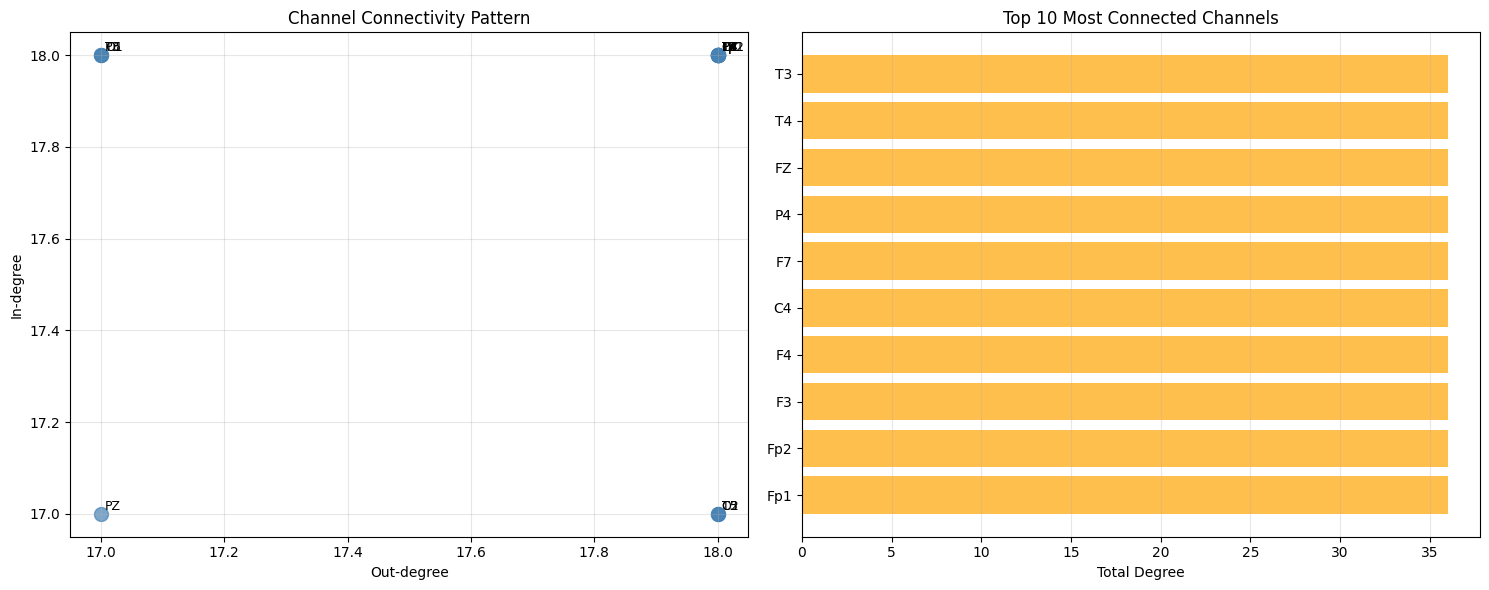

In [33]:
def analyze_connectivity_statistics(gc_matrix, p_values, channel_names, alpha=0.05, save_dir=None):
    """Analyze connectivity statistics and create visualizations"""
    
    # Calculate basic stats
    significant_mask = p_values < alpha
    n_total = len(channel_names) * (len(channel_names) - 1)
    n_significant = np.sum(significant_mask)
    
    print(f"CONNECTIVITY SUMMARY")
    print(f"Significant: {n_significant}/{n_total} ({n_significant/n_total*100:.1f}%)")
    
    # Node statistics
    out_degree = np.sum(significant_mask, axis=1)
    in_degree = np.sum(significant_mask, axis=0)
    
    node_stats = pd.DataFrame({
        'Channel': channel_names,
        'Out': out_degree,
        'In': in_degree,
        'Total': out_degree + in_degree
    }).sort_values('Total', ascending=False)
    
    print(f"\nTOP CONNECTED CHANNELS")
    print(node_stats.head(10).to_string(index=False))
    
    # Top connections
    connections_df = None
    if n_significant > 0:
        # Vectorized approach for finding significant connections
        sig_i, sig_j = np.where(significant_mask)
        connections_df = pd.DataFrame({
            'Source': [channel_names[i] for i in sig_i],
            'Target': [channel_names[j] for j in sig_j],
            'F-stat': gc_matrix[sig_i, sig_j],
            'p-value': p_values[sig_i, sig_j]
        }).sort_values('F-stat', ascending=False)
        
        print(f"\nTOP 10 STRONGEST CONNECTIONS")
        print(connections_df.head(10).to_string(index=False))
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot
    ax1.scatter(node_stats['Out'], node_stats['In'], s=100, alpha=0.7, color='steelblue')
    for _, row in node_stats.iterrows():
        ax1.annotate(row['Channel'], (row['Out'], row['In']), 
                    xytext=(3, 3), textcoords='offset points', fontsize=9)
    ax1.set_xlabel('Out-degree')
    ax1.set_ylabel('In-degree')
    ax1.set_title('Channel Connectivity Pattern')
    ax1.grid(True, alpha=0.3)
    
    # Bar plot
    top10 = node_stats.head(10)
    ax2.barh(range(len(top10)), top10['Total'], color='orange', alpha=0.7)
    ax2.set_yticks(range(len(top10)))
    ax2.set_yticklabels(top10['Channel'])
    ax2.set_xlabel('Total Degree')
    ax2.set_title('Top 10 Most Connected Channels')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'connectivity_statistics.png'), 
                   dpi=300, bbox_inches='tight')
    plt.show()
    
    return node_stats, connections_df

# Run analysis
node_stats, connections_df = analyze_connectivity_statistics(
    gc_matrix, p_values, channel_names, save_dir=output_dir
)

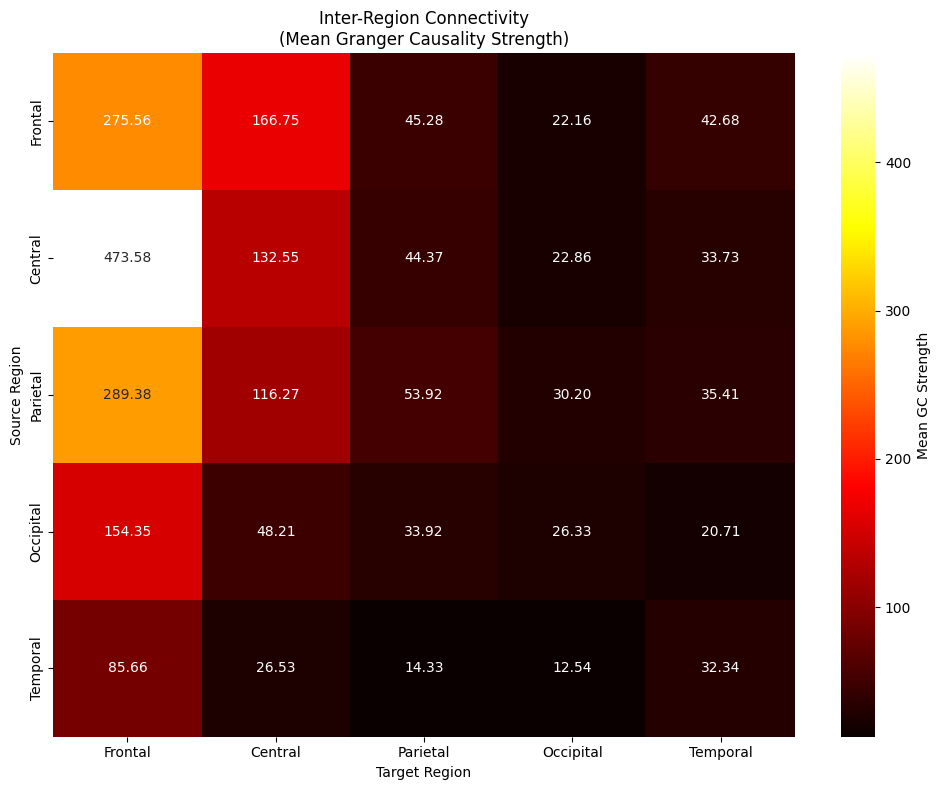


BRAIN REGION CONNECTIVITY SUMMARY
Frontal → Frontal: 275.559
Frontal → Central: 166.748
Frontal → Parietal: 45.281
Frontal → Occipital: 22.155
Frontal → Temporal: 42.680
Central → Frontal: 473.584
Central → Central: 132.550
Central → Parietal: 44.370
Central → Occipital: 22.857
Central → Temporal: 33.731
Parietal → Frontal: 289.375
Parietal → Central: 116.266
Parietal → Parietal: 53.918
Parietal → Occipital: 30.201
Parietal → Temporal: 35.408
Occipital → Frontal: 154.355
Occipital → Central: 48.209
Occipital → Parietal: 33.916
Occipital → Occipital: 26.335
Occipital → Temporal: 20.711
Temporal → Frontal: 85.657
Temporal → Central: 26.531
Temporal → Parietal: 14.325
Temporal → Occipital: 12.536
Temporal → Temporal: 32.339


In [34]:
def analyze_brain_regions(gc_matrix, p_values, channel_names, alpha=0.05, save_path=None):
    """Analyze connectivity patterns by brain regions"""
    
    # Define brain regions
    regions = {
        'Frontal': ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'FZ'],
        'Central': ['C3', 'C4', 'CZ'],
        'Parietal': ['P3', 'P4', 'PZ'],
        'Occipital': ['O1', 'O2'],
        'Temporal': ['T3', 'T4', 'T5', 'T6']
    }
    
    # Create channel to region mapping
    ch_to_region = {ch: region for region, channels in regions.items() 
                    for ch in channels if ch in channel_names}
    
    # Get significant connections
    sig_mask = p_values < alpha
    region_names = list(regions.keys())
    region_matrix = np.zeros((len(region_names), len(region_names)))
    
    # Calculate region-to-region connectivity
    for i, src_region in enumerate(region_names):
        for j, tgt_region in enumerate(region_names):
            # Find all connections between these regions
            strengths = []
            for src_ch in channel_names:
                for tgt_ch in channel_names:
                    if (src_ch in ch_to_region and tgt_ch in ch_to_region and
                        ch_to_region[src_ch] == src_region and 
                        ch_to_region[tgt_ch] == tgt_region and 
                        src_ch != tgt_ch):
                        
                        src_idx, tgt_idx = channel_names.index(src_ch), channel_names.index(tgt_ch)
                        if sig_mask[src_idx, tgt_idx]:
                            strengths.append(gc_matrix[src_idx, tgt_idx])
            
            region_matrix[i, j] = np.mean(strengths) if strengths else 0
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(region_matrix, 
                xticklabels=region_names, 
                yticklabels=region_names,
                annot=True, fmt='.2f', cmap='hot',
                cbar_kws={'label': 'Mean GC Strength'})
    
    plt.title('Inter-Region Connectivity\n(Mean Granger Causality Strength)')
    plt.xlabel('Target Region')
    plt.ylabel('Source Region')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\nBRAIN REGION CONNECTIVITY SUMMARY")
    for i, src in enumerate(region_names):
        for j, tgt in enumerate(region_names):
            if region_matrix[i, j] > 0:
                print(f"{src} → {tgt}: {region_matrix[i, j]:.3f}")
    
    return region_matrix

# Run analysis
region_matrix = analyze_brain_regions(
    gc_matrix, p_values, channel_names, 
    save_path=os.path.join(output_dir, 'brain_region_connectivity.png')
)

## 5. Interpretation and Saving Results

This analysis provides insights into the causal relationships between different brain regions in infant EEG data:

In [35]:
print("Saving results...")

# Save numpy arrays
for name, data in [('gc_matrix', gc_matrix), ('p_values', p_values), ('significant_gc', significant_gc)]:
    np.save(f"{output_dir}/{name}.npy", data)

# Save text and CSV files  
open(f"{output_dir}/channel_names.txt", 'w').write('\n'.join(channel_names))
if connections_df is not None: connections_df.to_csv(f"{output_dir}/significant_connections.csv", index=False)
if node_stats is not None: node_stats.to_csv(f"{output_dir}/node_statistics.csv", index=False)

print(f"Results saved to: {output_dir}")

Saving results...
Results saved to: ./Dataset/Infants_data_output/sub-NORB00003_ses-1_task-EEG_eeg


## 6. Time Window Comparison Analysis

This section analyzes how Granger causality patterns change across different time windows within the same recording. This can reveal:
- Temporal stability of connectivity patterns
- Dynamic changes in brain network organization
- Developmental fluctuations in neural interactions

In [36]:
def segment_data_into_windows(data, window_length_sec, overlap_ratio=0.5, sampling_freq=100):
    """Segment EEG data into overlapping time windows"""
    
    window_samples = int(window_length_sec * sampling_freq)
    step_samples = int(window_samples * (1 - overlap_ratio))
    
    windows = []
    window_info = []
    
    for start_idx in range(0, data.shape[1] - window_samples + 1, step_samples):
        end_idx = start_idx + window_samples
        
        # Extract window and create info
        windows.append(data[:, start_idx:end_idx])
        window_info.append({
            'window_idx': len(windows) - 1,
            'start_time': start_idx / sampling_freq,
            'end_time': end_idx / sampling_freq,
            'duration': window_length_sec
        })
    
    print(f"Created {len(windows)} windows of {window_length_sec}s each (overlap: {overlap_ratio*100:.0f}%)")
    
    return windows, window_info

# Quick test setup
window_sizes = [2, 4, 6]  
duration = eeg_subset.shape[1] / new_fs
print(f"Available data: {duration:.1f}s | Testing windows: {window_sizes}s")

Available data: 320.0s | Testing windows: [2, 4, 6]s


In [37]:
WINDOW_LENGTH_SEC = 4

def calculate_gc_across_windows(data, channel_names, window_length_sec=WINDOW_LENGTH_SEC, 
                                overlap_ratio=0.5, sampling_freq=100, max_lag=3):
    """Calculate Granger causality across multiple time windows"""
    
    # Segment data
    windows, window_info = segment_data_into_windows(
        data, window_length_sec, overlap_ratio, sampling_freq
    )
    
    n_channels = len(channel_names)
    gc_results = {
        'gc_matrices': [],
        'p_value_matrices': [],
        'significant_matrices': [],
        'window_info': window_info
    }
    
    print(f"Calculating GC for {len(windows)} windows of {window_length_sec}s each...")
    
    for i, window_data in enumerate(windows):
        print(f"Window {i+1}/{len(windows)}: ", end="")
        
        try:
            # Calculate GC and significance
            gc_matrix, p_values = calculate_granger_causality(
                window_data, channel_names, max_lag=max_lag
            )
            significant_gc = apply_significance_threshold(gc_matrix, p_values)
            
            # Store results
            gc_results['gc_matrices'].append(gc_matrix)
            gc_results['p_value_matrices'].append(p_values)
            gc_results['significant_matrices'].append(significant_gc)
            
            print(f"✓ {np.sum(significant_gc > 0)} connections")
            
        except Exception as e:
            print(f"✗ {e}")
            # Add zero matrices for failed windows
            zero_matrix = np.zeros((n_channels, n_channels))
            one_matrix = np.ones((n_channels, n_channels))
            
            gc_results['gc_matrices'].append(zero_matrix)
            gc_results['p_value_matrices'].append(one_matrix)
            gc_results['significant_matrices'].append(zero_matrix)
    
    return gc_results

# Run analysis with your configured window length
print(f"ANALYZING {WINDOW_LENGTH_SEC}-SECOND WINDOWS")
gc_windows_custom = calculate_gc_across_windows(
    eeg_subset, channel_names, 
    window_length_sec=WINDOW_LENGTH_SEC,
    overlap_ratio=0.3,
    sampling_freq=new_fs,
    max_lag=3
)

ANALYZING 4-SECOND WINDOWS
Created 113 windows of 4s each (overlap: 30%)
Calculating GC for 113 windows of 4s each...
Window 1/113: Calculating Granger causality for 19 channels...
✓ 210 connections
Window 2/113: Calculating Granger causality for 19 channels...
✓ 171 connections
Window 3/113: Calculating Granger causality for 19 channels...
✓ 136 connections
Window 4/113: Calculating Granger causality for 19 channels...
✓ 106 connections
Window 5/113: Calculating Granger causality for 19 channels...
✓ 213 connections
Window 6/113: Calculating Granger causality for 19 channels...
✓ 252 connections
Window 7/113: Calculating Granger causality for 19 channels...
✓ 168 connections
Window 8/113: Calculating Granger causality for 19 channels...
✓ 233 connections
Window 9/113: Calculating Granger causality for 19 channels...
✓ 190 connections
Window 10/113: Calculating Granger causality for 19 channels...
✓ 170 connections
Window 11/113: Calculating Granger causality for 19 channels...
✓ 163 c

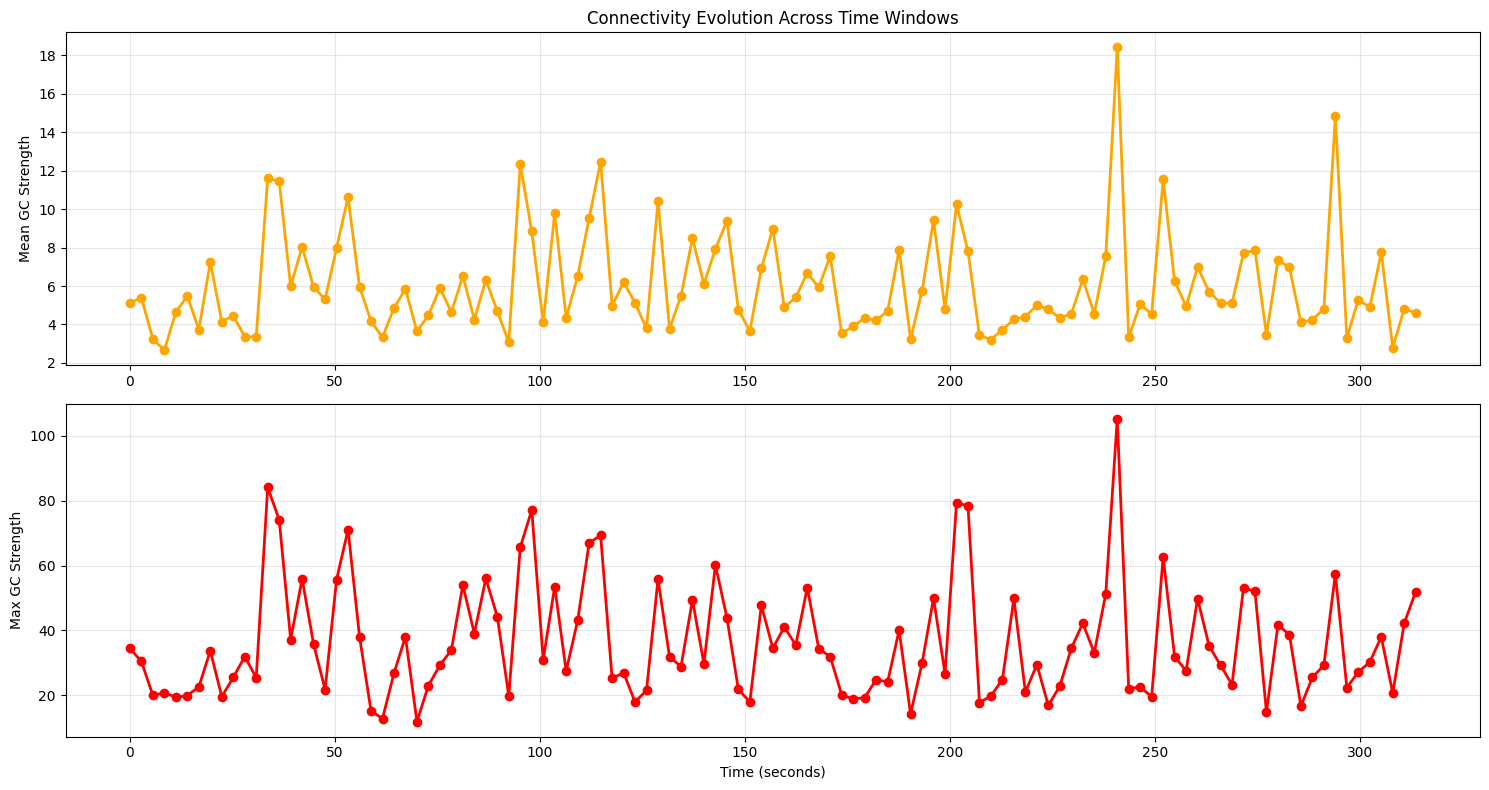

In [38]:
def plot_connectivity_evolution(gc_results, channel_names, save_path=None):
    """Plot how connectivity evolves across time windows"""
    
    gc_matrices = gc_results['gc_matrices']
    window_info = gc_results['window_info']
    
    # Calculate metrics for each window
    metrics = []
    for i, gc_matrix in enumerate(gc_matrices):
        total_conn = np.sum(gc_matrix > 0)
        mean_strength = np.mean(gc_matrix[gc_matrix > 0]) if total_conn > 0 else 0
        
        metrics.append({
            'start_time': window_info[i]['start_time'],
            'total_connections': total_conn,
            'mean_strength': mean_strength,
            'max_strength': np.max(gc_matrix)
        })
    
    metrics_df = pd.DataFrame(metrics)
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    
    # Plot mean strength
    ax1.plot(metrics_df['start_time'], metrics_df['mean_strength'], 'o-', color='orange', linewidth=2)
    ax1.set_title('Connectivity Evolution Across Time Windows')
    ax1.set_ylabel('Mean GC Strength')
    ax1.grid(True, alpha=0.3)
    
    # Plot max strength
    ax2.plot(metrics_df['start_time'], metrics_df['max_strength'], 'o-', color='red', linewidth=2)
    ax2.set_ylabel('Max GC Strength')
    ax2.set_xlabel('Time (seconds)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return metrics_df

# Plot connectivity evolution
metrics_df = plot_connectivity_evolution(
    gc_windows_custom, channel_names,
    save_path=os.path.join(output_dir, 'connectivity_evolution.png')
)

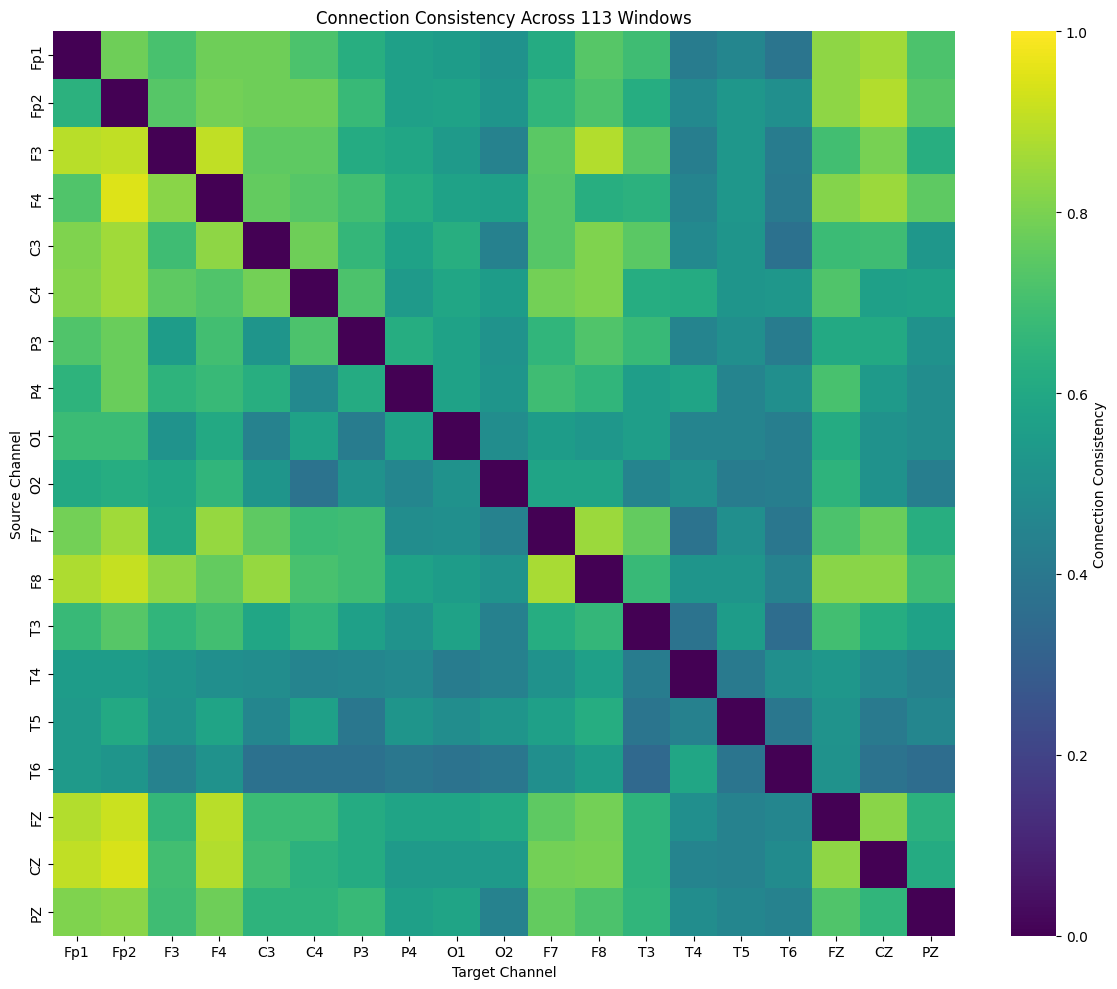


MOST STABLE CONNECTIONS (256 found)
    source target  consistency
47      F4    Fp2     0.946903
228     CZ    Fp2     0.938053
213     FZ    Fp2     0.920354
159     F8    Fp2     0.911504
227     CZ    Fp1     0.902655
32      F3    Fp2     0.902655
33      F3     F4     0.902655
31      F3    Fp1     0.893805
215     FZ     F4     0.893805
40      F3     F8     0.884956
212     FZ    Fp1     0.884956
230     CZ     F4     0.884956
29     Fp2     CZ     0.884956
158     F8    Fp1     0.876106
168     F8     F7     0.867257


In [39]:
def analyze_connectivity_stability(gc_results, channel_names, save_path=None):
    """Analyze stability of connectivity patterns across time windows"""
    
    significant_matrices = gc_results['significant_matrices']
    n_windows = len(significant_matrices)
    n_channels = len(channel_names)
    
    # Calculate connection consistency (vectorized approach)
    consistency = np.zeros((n_channels, n_channels))
    
    for i in range(n_channels):
        for j in range(n_channels):
            if i != j:
                consistency[i, j] = sum(matrix[i, j] > 0 for matrix in significant_matrices) / n_windows
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(consistency, 
                xticklabels=channel_names, 
                yticklabels=channel_names,
                cmap='viridis', 
                vmin=0, vmax=1,
                cbar_kws={'label': 'Connection Consistency'})
    
    plt.title(f'Connection Consistency Across {n_windows} Windows')
    plt.xlabel('Target Channel')
    plt.ylabel('Source Channel')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Find stable connections (>50% consistency)
    stable_list = []
    for i in range(n_channels):
        for j in range(n_channels):
            if i != j and consistency[i, j] > 0.5:
                stable_list.append({
                    'source': channel_names[i],
                    'target': channel_names[j],
                    'consistency': consistency[i, j]
                })
    
    if stable_list:
        stable_df = pd.DataFrame(stable_list).sort_values('consistency', ascending=False)
        print(f"\nMOST STABLE CONNECTIONS ({len(stable_list)} found)")
        print(stable_df.head(15))
        return consistency, stable_df
    else:
        print("\nNo highly stable connections found (>50% consistency)")
        return consistency, None

# Usage
consistency_matrix, stable_connections = analyze_connectivity_stability(
    gc_windows_custom, channel_names,
    save_path=os.path.join(output_dir, 'connectivity_stability.png')
)

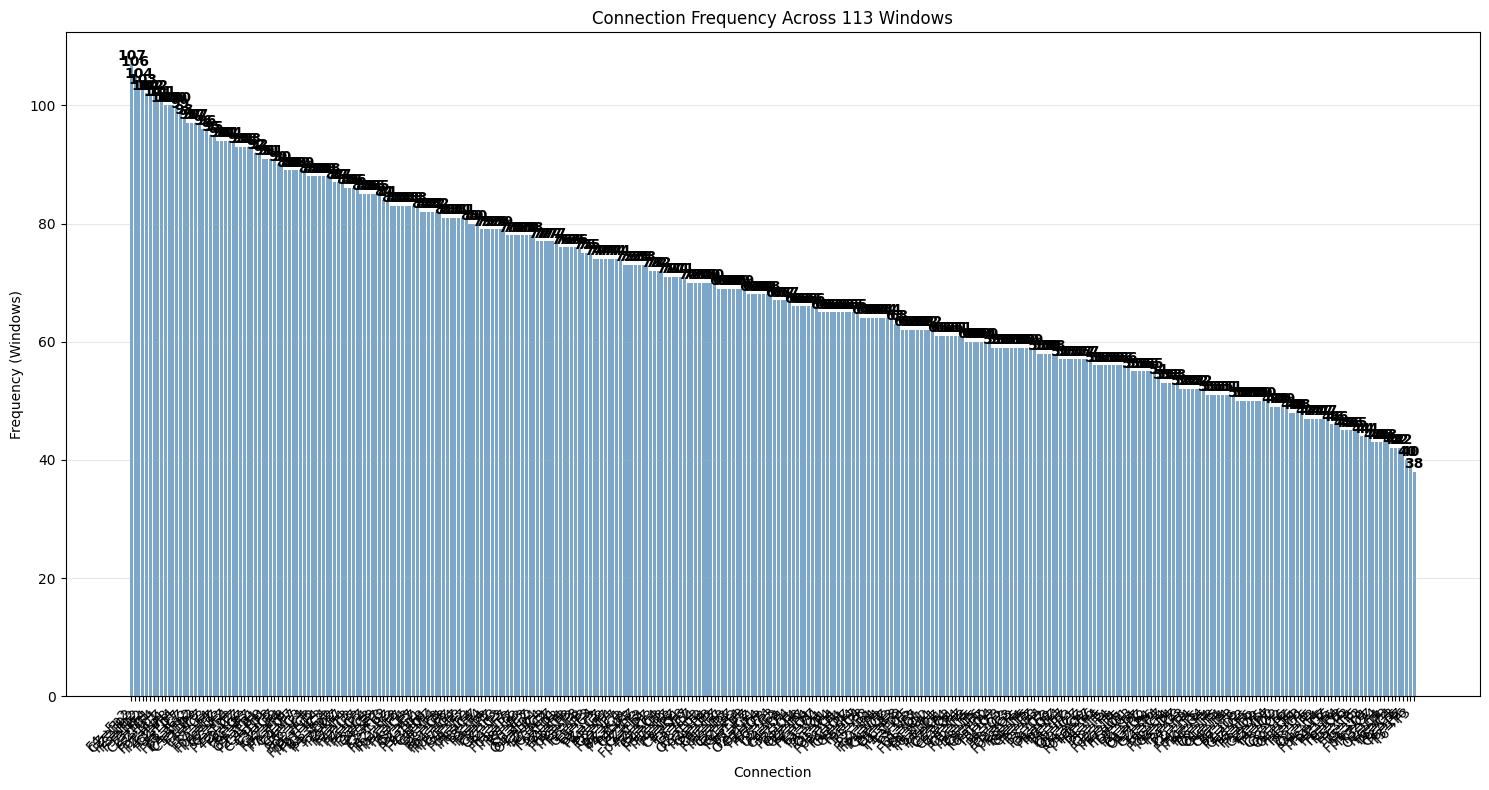


TOP 10 CONNECTIONS
 1. F4→Fp2: 107/113 (94.7%)
 2. CZ→Fp2: 106/113 (93.8%)
 3. FZ→Fp2: 104/113 (92.0%)
 4. F8→Fp2: 103/113 (91.2%)
 5. F3→Fp2: 102/113 (90.3%)
 6. F3→F4: 102/113 (90.3%)
 7. CZ→Fp1: 102/113 (90.3%)
 8. FZ→F4: 101/113 (89.4%)
 9. F3→Fp1: 101/113 (89.4%)
10. Fp2→CZ: 100/113 (88.5%)


In [40]:
def plot_connection_frequency(gc_results, channel_names, min_frequency=1, save_path=None):
    """Plot frequency of connections across time windows"""
    
    matrices = gc_results['significant_matrices']
    n_windows = len(matrices)
    n_channels = len(channel_names)
    
    # Count connection frequencies
    frequencies = []
    names = []
    
    for i in range(n_channels):
        for j in range(n_channels):
            if i != j:
                count = sum(matrix[i, j] > 0 for matrix in matrices)
                if count >= min_frequency:
                    frequencies.append(count)
                    names.append(f"{channel_names[i]}→{channel_names[j]}")
    
    if not frequencies:
        print(f"No connections found with frequency ≥ {min_frequency}")
        return None
    
    # Sort by frequency
    sorted_data = sorted(zip(frequencies, names), reverse=True)
    frequencies, names = zip(*sorted_data)
    
    # Plot
    plt.figure(figsize=(15, 8))
    bars = plt.bar(range(len(frequencies)), frequencies, color='steelblue', alpha=0.7)
    
    plt.xlabel('Connection')
    plt.ylabel('Frequency (Windows)')
    plt.title(f'Connection Frequency Across {n_windows} Windows')
    plt.xticks(range(len(names)), names, rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)
    
    # Add value labels
    for bar, freq in zip(bars, frequencies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(freq), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print top connections
    print(f"\nTOP 10 CONNECTIONS")
    for i, (freq, name) in enumerate(zip(frequencies[:10], names[:10])):
        print(f"{i+1:2d}. {name}: {freq}/{n_windows} ({freq/n_windows*100:.1f}%)")
    
    return frequencies, names

# Usage - Fixed variable name
result = plot_connection_frequency(
    gc_windows_custom, channel_names,
    min_frequency=1,
    save_path=os.path.join(output_dir, 'connection_frequency.png')
)

In [41]:
def compare_window_sizes(data, channel_names, window_sizes, sampling_freq):
    """Compare connectivity patterns across different window sizes"""
    results = {}
    
    for size in window_sizes:
        print(f"\nAnalyzing {size}s windows...")
        results[size] = calculate_gc_across_windows(
            data, channel_names,
            window_length_sec=size,
            overlap_ratio=0.3,
            sampling_freq=sampling_freq,
            max_lag=3
        )
    
    return results

# Smart window size selection
duration = eeg_subset.shape[1] / new_fs
print(f"Available data: {duration:.1f}s")

# Auto-select window sizes based on data length
if duration > 20:
    window_sizes = [2, 4, 6]
elif duration > 12:
    window_sizes = [2, 4, 6]
elif duration > 8:
    window_sizes = [2, 4]
else:
    window_sizes = [2]

print(f"Testing windows: {window_sizes}s")

# Run comparison if we have enough data
if duration > min(window_sizes) * 3:
    window_comparison = compare_window_sizes(eeg_subset, channel_names, window_sizes, new_fs)
else:
    print("Insufficient data for comparison")
    window_comparison = None

Available data: 320.0s
Testing windows: [2, 4, 6]s

Analyzing 2s windows...
Created 228 windows of 2s each (overlap: 30%)
Calculating GC for 228 windows of 2s each...
Window 1/228: Calculating Granger causality for 19 channels...
✓ 188 connections
Window 2/228: Calculating Granger causality for 19 channels...
✓ 178 connections
Window 3/228: Calculating Granger causality for 19 channels...
✓ 181 connections
Window 4/228: Calculating Granger causality for 19 channels...
✓ 137 connections
Window 5/228: Calculating Granger causality for 19 channels...
✓ 142 connections
Window 6/228: Calculating Granger causality for 19 channels...
✓ 133 connections
Window 7/228: Calculating Granger causality for 19 channels...
✓ 72 connections
Window 8/228: Calculating Granger causality for 19 channels...
✓ 113 connections
Window 9/228: Calculating Granger causality for 19 channels...
✓ 142 connections
Window 10/228: Calculating Granger causality for 19 channels...
✓ 185 connections
Window 11/228: Calculat

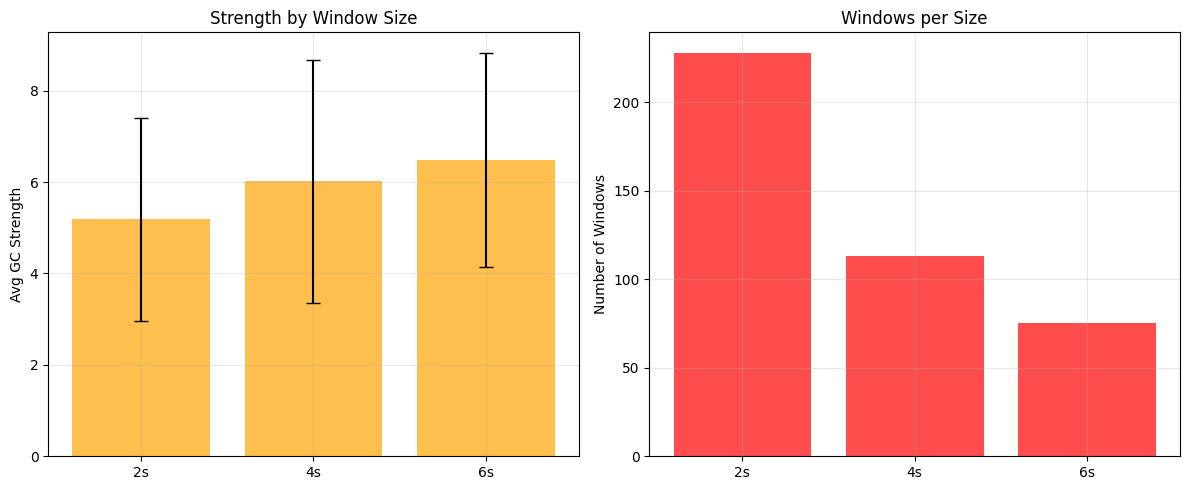


WINDOW SIZE COMPARISON
2s: 228 windows, avg strength: 5.187±2.223
4s: 113 windows, avg strength: 6.016±2.661
6s: 75 windows, avg strength: 6.491±2.342


In [42]:
def plot_window_size_comparison(window_comparison, channel_names, save_path=None):
    """Plot comparison of connectivity metrics across different window sizes"""
    if window_comparison is None:
        print("No window comparison data available")
        return
    
    window_sizes = list(window_comparison.keys())
    
    # Collect metrics for each window size
    stats = {}
    for size in window_sizes:
        matrices = window_comparison[size]['gc_matrices']
        connections = [np.sum(matrix > 0) for matrix in matrices]
        strengths = [np.mean(matrix[matrix > 0]) if np.sum(matrix > 0) > 0 else 0 
                    for matrix in matrices]
        
        stats[size] = {
            'avg_strength': np.mean(strengths),
            'std_strength': np.std(strengths),
            'num_windows': len(matrices)
        }
    
    # Create 1x2 subplot (only 2 plots now)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    colors = ['orange', 'red']
    
    # Plot 1: Average strength
    sizes_labels = [f'{size}s' for size in window_sizes]
    avg_str = [stats[size]['avg_strength'] for size in window_sizes]
    std_str = [stats[size]['std_strength'] for size in window_sizes]
    
    axes[0].bar(sizes_labels, avg_str, yerr=std_str, capsize=5, 
                alpha=0.7, color=colors[0])
    axes[0].set_ylabel('Avg GC Strength')
    axes[0].set_title('Strength by Window Size')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Number of windows
    n_windows = [stats[size]['num_windows'] for size in window_sizes]
    
    axes[1].bar(sizes_labels, n_windows, alpha=0.7, color=colors[1])
    axes[1].set_ylabel('Number of Windows')
    axes[1].set_title('Windows per Size')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\nWINDOW SIZE COMPARISON")
    for size in window_sizes:
        s = stats[size]
        print(f"{size}s: {s['num_windows']} windows, "
              f"avg strength: {s['avg_strength']:.3f}±{s['std_strength']:.3f}")

# Usage
if window_comparison:
    plot_window_size_comparison(
        window_comparison, channel_names,
        save_path=os.path.join(output_dir, 'window_size_comparison.png')
    )


=== TEMPORAL DYNAMICS ===


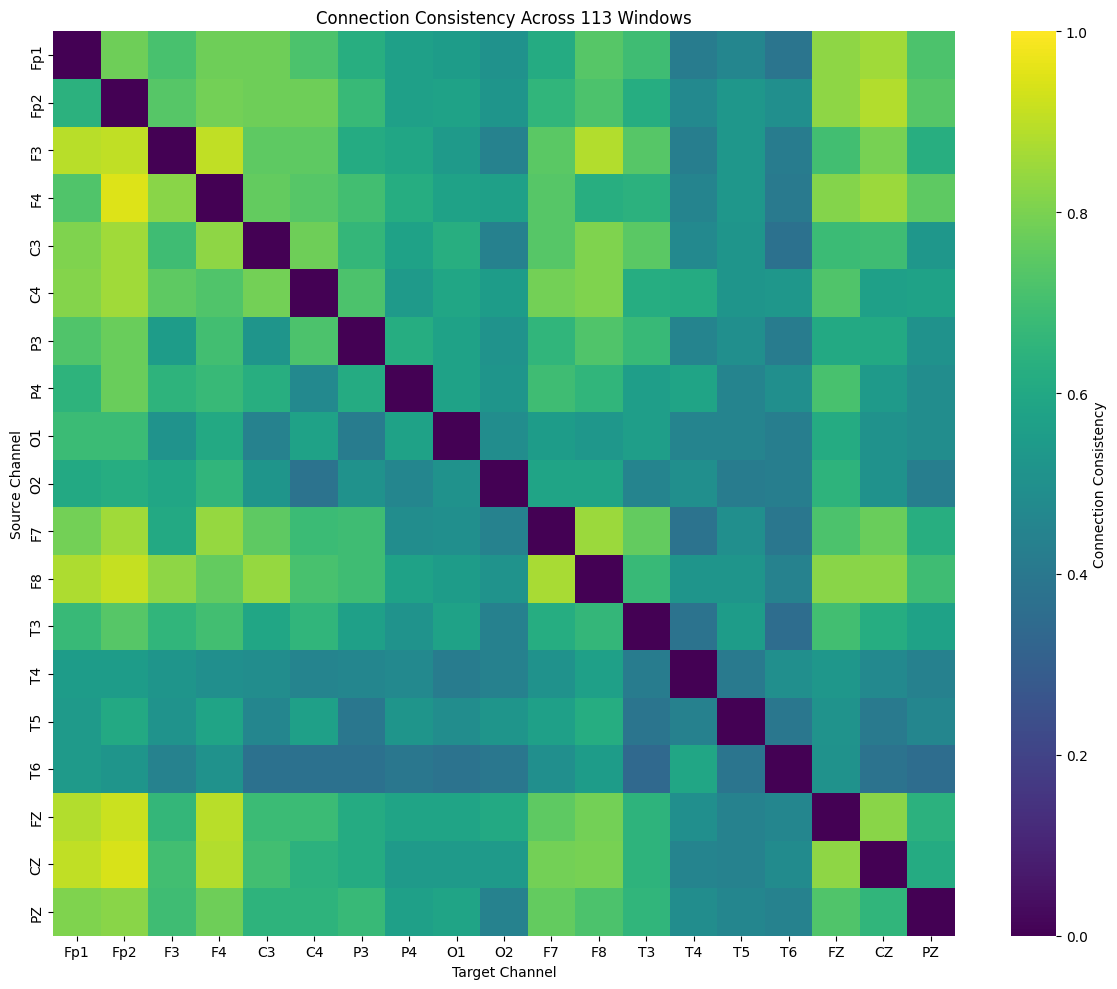


MOST STABLE CONNECTIONS (256 found)
    source target  consistency
47      F4    Fp2     0.946903
228     CZ    Fp2     0.938053
213     FZ    Fp2     0.920354
159     F8    Fp2     0.911504
227     CZ    Fp1     0.902655
32      F3    Fp2     0.902655
33      F3     F4     0.902655
31      F3    Fp1     0.893805
215     FZ     F4     0.893805
40      F3     F8     0.884956
212     FZ    Fp1     0.884956
230     CZ     F4     0.884956
29     Fp2     CZ     0.884956
158     F8    Fp1     0.876106
168     F8     F7     0.867257


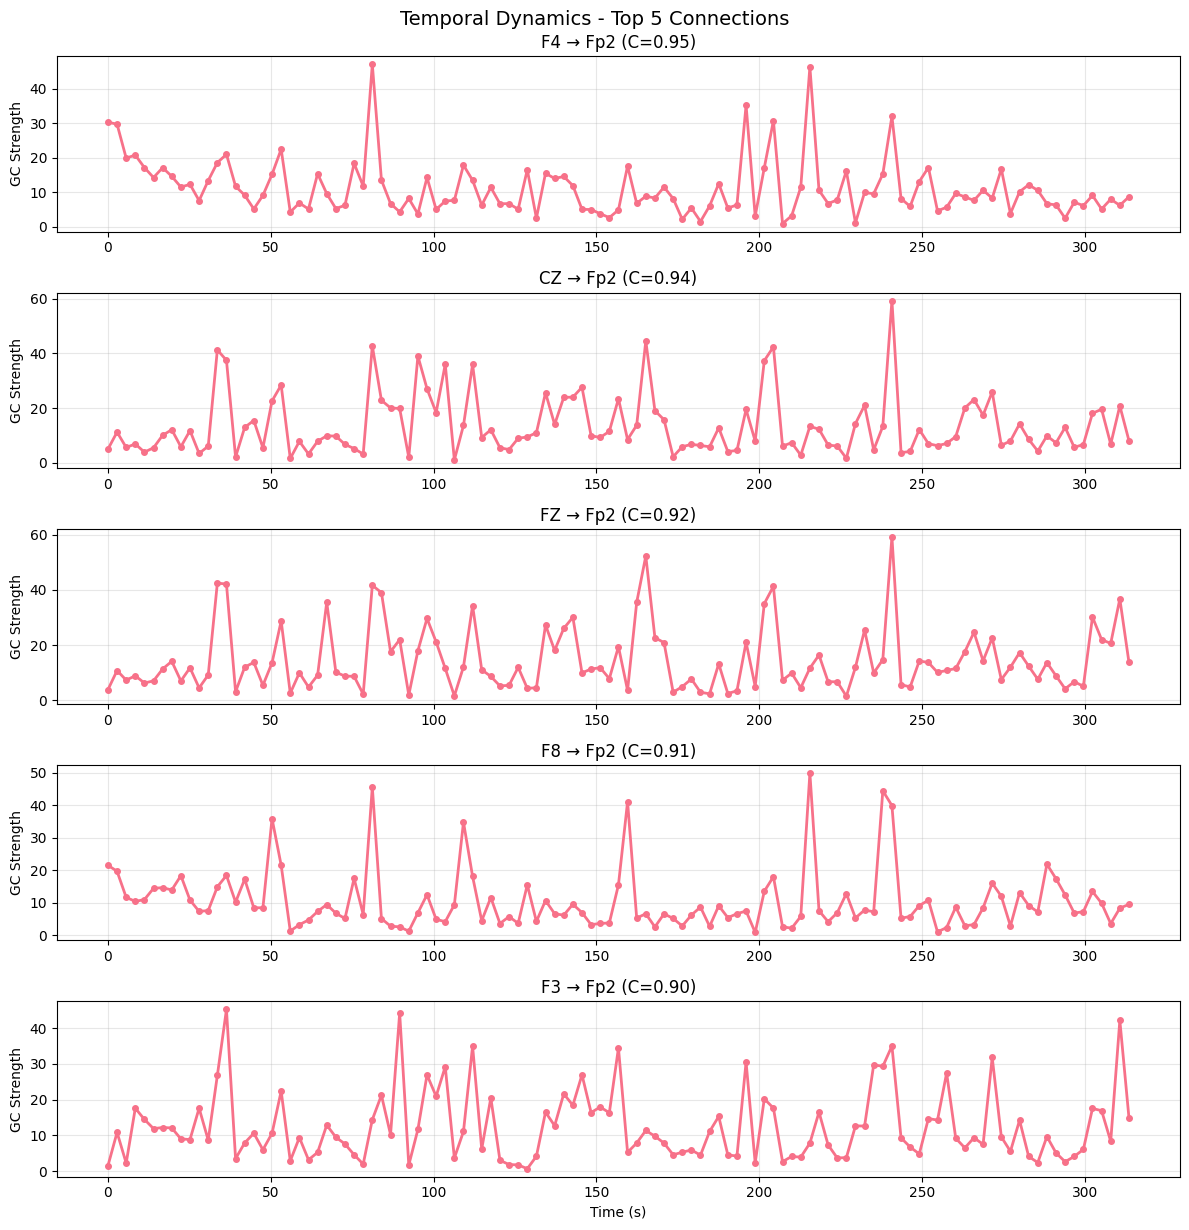

Analyzed 5 strongest connections:
  F4 → Fp2: 0.947
  CZ → Fp2: 0.938
  FZ → Fp2: 0.920
  F8 → Fp2: 0.912
  F3 → Fp2: 0.903


In [43]:
def analyze_temporal_dynamics(gc_results, channel_names, max_pairs=5, save_path=None):
    """Analyze temporal evolution of strongest connections"""
    
    # Get data
    gc_matrices = gc_results['gc_matrices']
    window_info = gc_results['window_info']
    
    # Find most consistent connections
    consistency_matrix, _ = analyze_connectivity_stability(gc_results, channel_names)
    
    # Get top connections (simplified selection)
    top_pairs = []
    for i in range(len(channel_names)):
        for j in range(len(channel_names)):
            if i != j and consistency_matrix[i, j] > 0.2:  # Lower threshold
                top_pairs.append((i, j, consistency_matrix[i, j]))
    
    # Sort and limit
    top_pairs = sorted(top_pairs, key=lambda x: x[2], reverse=True)[:max_pairs]
    
    if not top_pairs:
        print("No stable connections found")
        return None
    
    # Plot evolution
    n_pairs = len(top_pairs)
    fig, axes = plt.subplots(n_pairs, 1, figsize=(12, 2.5*n_pairs))
    if n_pairs == 1: axes = [axes]
    
    for idx, (i, j, consistency) in enumerate(top_pairs):
        # Extract time series
        gc_values = [matrix[i, j] for matrix in gc_matrices]
        time_points = [info['start_time'] for info in window_info]
        
        # Plot
        axes[idx].plot(time_points, gc_values, 'o-', linewidth=2, markersize=4)
        axes[idx].set_title(f'{channel_names[i]} → {channel_names[j]} (C={consistency:.2f})')
        axes[idx].set_ylabel('GC Strength')
        axes[idx].grid(True, alpha=0.3)
        
        # X-label only on last plot
        if idx == n_pairs - 1:
            axes[idx].set_xlabel('Time (s)')
    
    plt.suptitle(f'Temporal Dynamics - Top {n_pairs} Connections', fontsize=14)
    plt.tight_layout()
    
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary
    print(f"Analyzed {n_pairs} strongest connections:")
    for i, j, c in top_pairs:
        print(f"  {channel_names[i]} → {channel_names[j]}: {c:.3f}")
    
    return top_pairs

# Usage (simplified)
if 'gc_windows_custom' in locals():
    print("\n=== TEMPORAL DYNAMICS ===")
    temporal_pairs = analyze_temporal_dynamics(
        gc_windows_custom, channel_names,
        save_path=os.path.join(output_dir, 'temporal_dynamics.png')
    )

In [44]:
# Save time window analysis results
print("\n=== SAVING RESULTS ===")

def save_results():
    """Save all analysis results and plots"""
    saved_files = []
    
    try:
        # Save main GC results
        for name, data in [('gc_matrix', gc_matrix), ('p_values', p_values), ('significant_gc', significant_gc)]:
            if name in globals():
                np.save(os.path.join(output_dir, f'{name}.npy'), data)
                saved_files.append(f'{name}.npy')
        
        # Save window analysis if available
        if 'gc_windows_custom' in locals():
            np.save(os.path.join(output_dir, 'window_matrices.npy'), gc_windows_custom['gc_matrices'])
            np.save(os.path.join(output_dir, 'window_pvalues.npy'), gc_windows_custom['p_value_matrices'])
            saved_files.extend(['window_matrices.npy', 'window_pvalues.npy'])
        
        # Save CSV files
        if 'connections_df' in locals() and connections_df is not None:
            connections_df.to_csv(os.path.join(output_dir, 'connections.csv'), index=False)
            saved_files.append('connections.csv')
            
        if 'node_stats' in locals():
            node_stats.to_csv(os.path.join(output_dir, 'node_stats.csv'), index=False)
            saved_files.append('node_stats.csv')
        
        # Save channel names
        with open(os.path.join(output_dir, 'channels.txt'), 'w') as f:
            f.write('\n'.join(channel_names))
        saved_files.append('channels.txt')
        
        print(f"✓ Saved {len(saved_files)} files to: {output_dir}")
        
    except Exception as e:
        print(f"Error saving: {e}")

# Save everything
save_results()
print("\n✓ ANALYSIS COMPLETE!")


=== SAVING RESULTS ===
✓ Saved 4 files to: ./Dataset/Infants_data_output/sub-NORB00003_ses-1_task-EEG_eeg

✓ ANALYSIS COMPLETE!


## 7. Time Window Analysis Summary

The time window analysis provides insights into:

### Temporal Stability
- **Connection Consistency**: How often specific connections appear across different time windows
- **Strength Variability**: How much connection strengths fluctuate over time
- **Network Dynamics**: Changes in overall connectivity patterns

### Window Size Effects
- **Optimal Window Length**: Balance between temporal resolution and statistical power
- **Detection Sensitivity**: Shorter windows may miss transient connections, longer windows may average out dynamics
- **Computational Efficiency**: Trade-off between detail and processing time

### Developmental Insights
- **Maturation Patterns**: Stable vs. variable connections may reflect different developmental stages
- **Functional Networks**: Consistent connections likely represent established neural pathways
- **Plasticity Indicators**: Variable connections may indicate ongoing neural plasticity

### Methodological Considerations
- **Statistical Power**: Longer windows provide more data points for robust GC estimation
- **Temporal Resolution**: Shorter windows better capture rapid neural dynamics
- **Overlap Strategy**: Window overlap affects independence of observations but improves temporal resolution